In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'fall','stand'
]
data = np.load("dataset/seq_fall-2023-1.npy")
datas = np.load("dataset/seq_stand-2023-1.npy")

for i in range(2,9):
    data = np.concatenate([
        data,
        np.load(f'dataset/seq_fall-2023-{i}.npy')
    ], axis=0)
    
# for i in range(1,2):
#     datas = np.concatenate([
#         datas,
#         np.load(f'dataset/raw_stand_{i}.npy')
#     ], axis=0)
# datas = np.concatenate([datas,np.load("dataset/seq_stand_2022.npy")], axis=0)
    
data = np.concatenate([data,datas])
print(data.shape)
print(datas.shape)

(1287, 30, 49)
(995, 30, 49)


In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)
print(labels[700:1000])


(1287, 30, 48)
(1287,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1287, 2)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.4,random_state=2022)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(772, 30, 48) (772, 2)
(515, 30, 48) (515, 2)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,Dropout

model = Sequential([
    GRU(64,dropout=0.3,return_sequences=True,input_shape=x_train.shape[1:3]),
    GRU(32,dropout=0.3),
    # Dropout(0.2),
    # Dense(32, activation='relu'),
    
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 30, 64)            21888     
                                                                 
 gru_19 (GRU)                (None, 32)                9408      
                                                                 
 dense_19 (Dense)            (None, 2)                 66        
                                                                 
Total params: 31,362
Trainable params: 31,362
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
24/25 [===========================>..] - ETA: 0s - loss: 0.4272 - acc: 0.8099
Epoch 1: val_acc improved from -inf to 0.88350, saving model to models\model.h5
25/25 [==============================] - 3s 34ms/step - loss: 0.4258 - acc: 0.8109 - val_loss: 0.3301 - val_acc: 0.8835 - lr: 0.0010
Epoch 2/200
24/25 [===========================>..] - ETA: 0s - loss: 0.2358 - acc: 0.9206
Epoch 2: val_acc improved from 0.88350 to 0.90874, saving model to models\model.h5
25/25 [==============================] - 0s 16ms/step - loss: 0.2348 - acc: 0.9210 - val_loss: 0.2499 - val_acc: 0.9087 - lr: 0.0010
Epoch 3/200
24/25 [===========================>..] - ETA: 0s - loss: 0.1052 - acc: 0.9688
Epoch 3: val_acc improved from 0.90874 to 0.93398, saving model to models\model.h5
25/25 [==============================] - 0s 16ms/step - loss: 0.1048 - acc: 0.9689 - val_loss: 0.1938 - val_acc: 0.9340 - lr: 0.0010
Epoch 4/200
23/25 [==========================>...] - ETA: 0s - loss: 0.0287 - acc: 0.

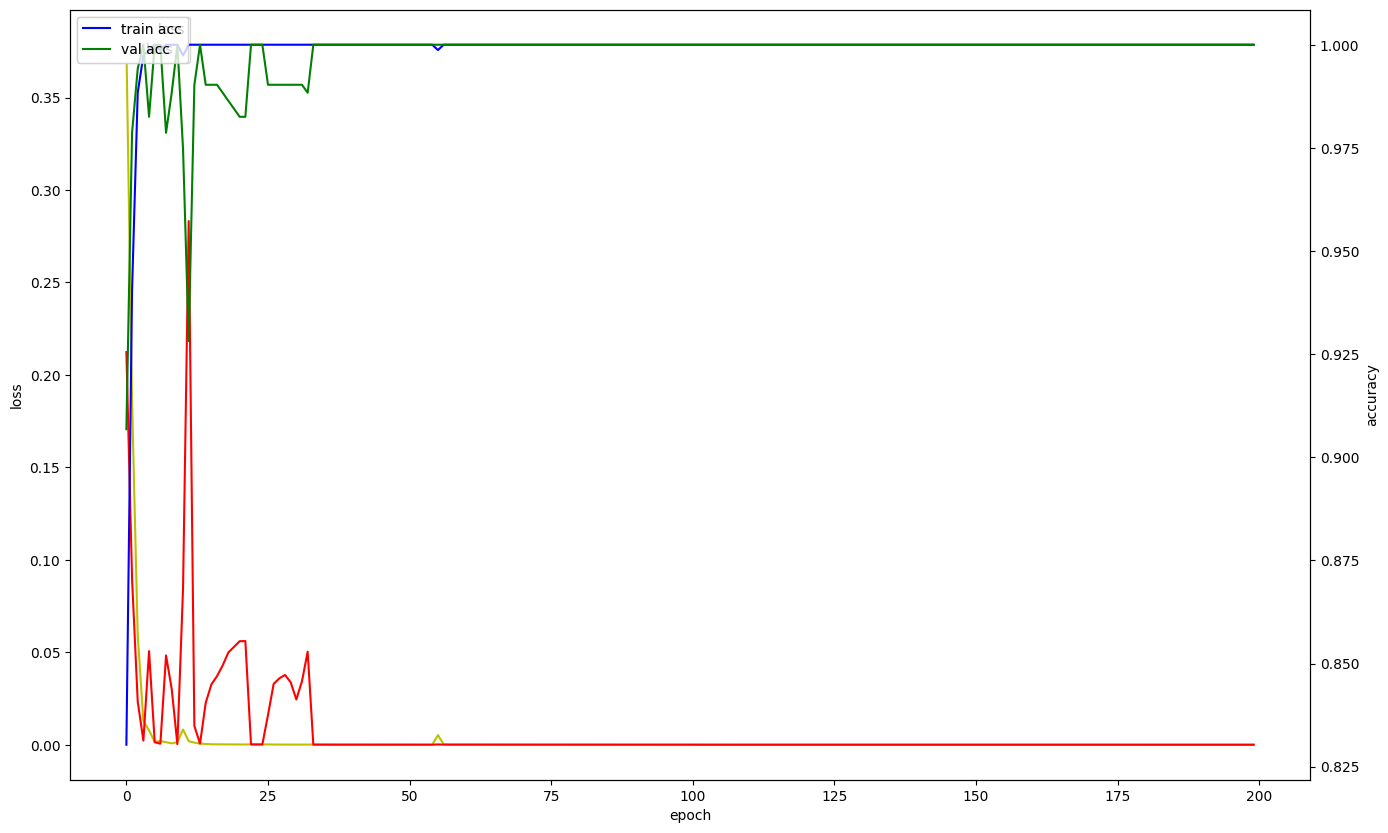

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

11/11 [==============================] - 0s 3ms/step


array([[[297,   0],
        [  0,  35]],

       [[ 35,   0],
        [  0, 297]]], dtype=int64)